In [1]:
from utils import gpu_cpu_test
gpu_cpu_test()

TF version - 1.8.0
Default GPU Device: /device:GPU:0
---------- -----------
Using device info: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7046558200174872028
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3225105203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13170367597238420401
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import easygui
import pandas as pd
from dataset_getter import open_dataset
from utils import save_history

In [3]:
from keras.layers import Input, Dense, Flatten, Reshape, Dropout
from keras.models import Model, load_model
from keras import backend as K

In [4]:
##### load and prepare data
x_train, x_test, _, _ = open_dataset()

загружаем 2д-датасет из файла C:\Users\milom\YandexDisk\Documents\Programming\Projects\Python\Deep Learning\DL_ECG\all_datasets_here\ELECTRIC_AXIS.pkl
409  записей 
y_train  имеет форму (274, 5)
x_train  имеет форму (274, 12, 1, 5000)
x_test   имеет форму (135, 12, 1, 5000)
y_test   имеет форму (135, 5)


In [5]:
n_channels=12
encoding_dim=2
ecg_segment_len = 256
x_train = np.swapaxes(x_train, 1, 3)
x_test = np.swapaxes(x_test, 1, 3)
x_train = x_train[:, 0:ecg_segment_len, :, :]
x_test = x_test[:, 0:ecg_segment_len, :, :]
print("после свопа со срезом x_test - " + str(x_test.shape))
print("после свопа со срезом x_train - " + str(x_train.shape))
#slice 5000 -> 252

после свопа со срезом x_test - (135, 256, 1, 12)
после свопа со срезом x_train - (274, 256, 1, 12)


In [6]:
input_data=Input(shape=(ecg_segment_len, 1, n_channels))
flat_data = Flatten()(input_data)

In [7]:
x=Dense(256,activation='elu')(flat_data)
x=Dense(128,activation='elu')(x)
x=Dense(32,activation='elu')(x)
x=Dense(16,activation='elu')(x)
encoded=Dense(encoding_dim,activation='linear')(x)

In [8]:
input_codes=Input(shape=(encoding_dim,))
x=Dense(16,activation='elu')(input_codes)
x=Dense(32,activation='elu')(x)
x=Dense(256,activation='elu')(x)
x=Dense(128,activation='elu')(x)
flat_decoded=Dense(ecg_segment_len*n_channels, activation='linear')(x)
decoded=Reshape((ecg_segment_len,1,n_channels))(flat_decoded)

In [9]:
encoder = Model(input_data, encoded, name='encoder')
decoder = Model(input_codes, decoded,name='decoder')
ae=Model(input_data,decoder(encoder(input_data)),name='autoencoder')

In [10]:
ae.summary()
ae.compile(optimizer='adam',loss='mean_squared_logarithmic_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 1, 12)        0         
_________________________________________________________________
encoder (Model)              (None, 2)                 824274    
_________________________________________________________________
decoder (Model)              (None, 256, 1, 12)        438224    
Total params: 1,262,498
Trainable params: 1,262,498
Non-trainable params: 0
_________________________________________________________________


In [11]:
train_history=ae.fit(x_train,x_train, epochs=100,batch_size=10,shuffle=True,validation_data=(x_test,x_test),callbacks=None)

Train on 274 samples, validate on 135 samples
Epoch 1/100
274/274 [==============================] - 2s 9ms/step - loss: 2.9579 - val_loss: 2.7642
Epoch 2/100
274/274 [==============================] - 0s 972us/step - loss: 2.5637 - val_loss: 2.5905
Epoch 3/100
274/274 [==============================] - 0s 950us/step - loss: 2.4069 - val_loss: 2.4776
Epoch 4/100
274/274 [==============================] - 0s 943us/step - loss: 2.2729 - val_loss: 2.3706
Epoch 5/100
274/274 [==============================] - 0s 925us/step - loss: 2.1666 - val_loss: 2.3139
Epoch 6/100
274/274 [==============================] - 0s 928us/step - loss: 2.0922 - val_loss: 2.2184
Epoch 7/100
274/274 [==============================] - 0s 972us/step - loss: 2.0225 - val_loss: 2.2050
Epoch 8/100
274/274 [==============================] - 0s 994us/step - loss: 1.9772 - val_loss: 2.1803
Epoch 9/100
274/274 [==============================] - 0s 961us/step - loss: 1.9380 - val_loss: 2.1760
Epoch 10/100
274/274 [=======

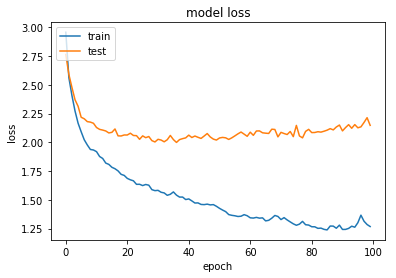

In [12]:
save_history(train_history,'ae_dense_manifold_reconstruction')
model_name='ae_dense'
ae.save(model_name+'.h5')
ae.save_weights(model_name+'_weights.h5')

In [13]:
#Visualization test
def show_reconstruction_by_ae(ecg_sample, name):
    filepath = easygui.fileopenbox("выберите файл с обученной моделью .h5")
    trained_model = load_model(filepath)

    ecg_sample = np.array([ecg_sample])
    prediction = trained_model.predict(ecg_sample)

    draw_reconstruction_to_png(ecg_sample[0],prediction[0], name)

def get_ecg_test_sample(num_patient):
    sample = x_test[num_patient,:,:,:]
    print("форма тензора с экг: "+ str(sample.shape))
    return sample

def draw_reconstruction_to_png(ecg_true, ecg_predicted, png_filename):
    """
    :param ecg_true: истинная экг
    :param ecg_predicted: предсказанное
    :param png_filename: имя для файла с картинкой
    :return:
    """
    ecg_true = reshape_ecg_tensor(ecg_true)
    ecg_predicted = reshape_ecg_tensor(ecg_predicted)

    assert ecg_true.shape == ecg_predicted.shape

    len_of_time = len(ecg_true[0])
    t = [i for i in range(len_of_time)]


    rows = len(ecg_true)  # кол-во каналов
    cols = 2              # true и predicted - 2 столбика
    f, axarr = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    for i in range(rows):
        true_i_chanel = ecg_true[i]
        predicted_i_chanel = ecg_predicted[i]
        axarr[i, 0].plot(t, true_i_chanel)
        axarr[i, 1].plot(t, predicted_i_chanel)


    plt.savefig(png_filename+".png")

def reshape_ecg_tensor(ecg):
    # превратим (256, 1, 12) в (12, 256)
    print ("форма тезора с экг =  " + str(ecg.shape))
    ecg = ecg[:,0,:]
    ecg = np.transpose(ecg)
    print ("форма тезора с экг(после изменения) =" + str(ecg))
    return ecg

форма тензора с экг: (256, 1, 12)
форма тезора с экг =  (256, 1, 12)
форма тезора с экг(после изменения) =[[ -6.02731365  -5.87472343  -5.87472343 ...  -5.87472343  -5.87472343
   -5.87472343]
 [-18.23453117 -18.08194095 -18.08194095 ... -27.23735409 -27.23735409
  -27.23735409]
 [-12.13092241 -12.13092241 -12.13092241 ... -21.28633555 -21.28633555
  -21.28633555]
 ...
 [  3.12809949   3.12809949   3.12809949 ...  -5.87472343  -5.87472343
   -5.87472343]
 [-24.33813993 -24.18554971 -24.18554971 ... -14.11459525 -13.50423438
  -12.74128328]
 [-30.44174868 -30.28915846 -30.28915846 ... -15.03013657 -15.03013657
  -15.03013657]]
форма тезора с экг =  (256, 1, 12)
форма тезора с экг(после изменения) =[[-0.57297635  0.27867442 -2.3058152  ...  0.48019397  0.31808355
   0.20246904]
 [-3.743806   -2.228918   -2.0694327  ... -2.32032    -1.3214879
  -1.7938564 ]
 [ 0.2518161   0.15946136 -0.37844005 ...  0.8174931   0.1672648
  -2.7847948 ]
 ...
 [ 2.334166    2.9058418   2.7190037  ...  0.555

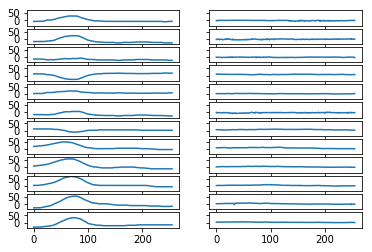

In [14]:
name = "ae_dense_manifold"
#model = train_canterpillar(name)
ecg_sample = get_ecg_test_sample(num_patient=0)
show_reconstruction_by_ae(ecg_sample, name)

In [15]:
def evaluate_interval_codes(x_test, encoder):
   code=encoder.predict(x_test, batch_size=10)
   mn=code.min()
   mx=code.max()
   return mn,mx
min_codes, max_codes= evaluate_interval_codes(x_test, encoder)

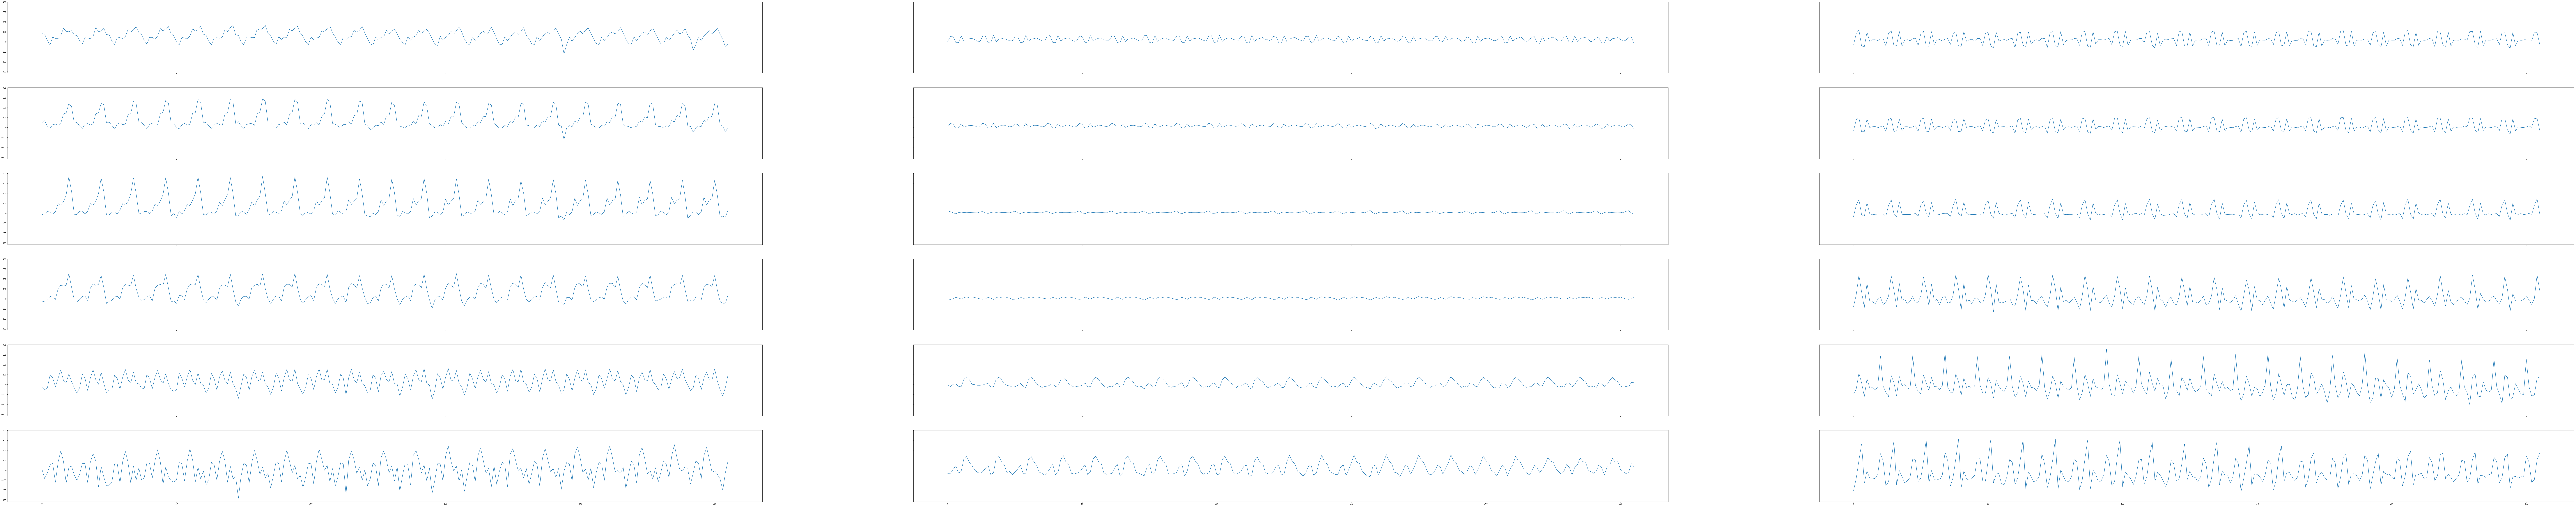

In [24]:
#rows=len(x_mean)
rows=6
cols=3
fig,axs=plt.subplots(figsize=(250,50),nrows=rows,ncols=cols,sharex=True,sharey=True)
#fig.set_size_inches(256,50)
y_list=np.linspace(min_codes,max_codes,rows)
x_list=np.linspace(min_codes,max_codes,cols)
for i,ax_y in enumerate(y_list):
    for j,ax_x in enumerate(x_list):
        code=(np.array([[ax_x, ax_y]]))
        x_mean=decoder.predict(code)
        x_mean=np.reshape(x_mean,(256,1,12))
        x_mean=np.reshape(x_mean,(12,256))
        len_of_time = len(x_mean[0])
        t = [i for i in range(len_of_time)]
        ecg_predicted=x_mean[0]
        axs[i,j].plot(t,ecg_predicted)
png_filename="manifold_dense_ae_2"
plt.savefig(png_filename+".png")